In [13]:
#!/usr/bin/env python3
import os
import numpy as np
import pathlib
import matplotlib.pyplot as plt
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add, Conv2D, Conv2DTranspose, Cropping2D, \
                                    Dropout, Input, MaxPool2D, Reshape,\
                                    Softmax, Cropping2D, ZeroPadding2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.preprocessing.image import array_to_img, load_img, save_img
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from src.architecture import SegmentationModel

%matplotlib inline

### Build the model structure

Notes: https://stackoverflow.com/questions/47787011/how-to-disable-dropout-while-prediction-in-keras

In [14]:
input_shape = (375, 1242, 3)

In [16]:
mm_model = SegmentationModel(input_shape)

NameError: name 'l2' is not defined

In [3]:
inputs = Input(shape=input_shape, name='inputs')

In [4]:
conv1_1 = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', name='conv1_1')(inputs)

In [5]:
conv1_2 = Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', name='conv1_2')(conv1_1)

In [6]:
pool1 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool1')(conv1_2)

In [7]:
conv2_1 = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', name='conv2_1')(pool1)

In [8]:
conv2_2 = Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='same', name='conv2_2')(conv2_1)

In [9]:
pool2 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool2')(conv2_2)

In [10]:
conv3_1 = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', name='conv3_1')(pool2)

In [11]:
conv3_2 = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', name='conv3_2')(conv3_1)

In [12]:
conv3_3 = Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='same', name='conv3_3')(conv3_2)

In [13]:
pool3 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool3')(conv3_3)

In [14]:
conv4_1 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', name='conv4_1')(pool3)

In [15]:
conv4_2 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', name='conv4_2')(conv4_1)

In [16]:
conv4_3 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', name='conv4_3')(conv4_2)

In [17]:
pool4 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool4')(conv4_3)

In [18]:
conv5_1 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', name='conv5_1')(pool4)

In [19]:
conv5_2 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', name='conv5_2')(conv5_1)

In [20]:
conv5_3 = Conv2D(filters=512, kernel_size=3, strides=(1, 1), padding='same', name='conv5_3')(conv5_2)

In [21]:
pool5 = MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same', name='pool5')(conv5_3)

In [22]:
fc6 = Conv2D(filters=4096, kernel_size=(7, 7), strides=(1, 1), padding='same', name='fc6')(pool5)

In [23]:
# This layer is disabled in predict mode. 
fc6 = Dropout(rate=0.5)(fc6)

In [24]:
fc7 = Conv2D(filters=4096, kernel_size=(1, 1), strides=(1, 1), padding='same', name='fc7')(fc6)

In [25]:
# This layer is disabled in predict mode. 
fc7 = Dropout(rate=0.5)(fc7)

In [26]:
score = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(l=(2/4096)**0.5), 
               name='score')(fc7)

In [27]:
upscore2 = Conv2DTranspose(filters=2, kernel_size=(4, 4), strides=(2, 2), padding='same', name='upscore2')(score)

In [28]:
score_pool4 = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1), kernel_regularizer=l2(l=0.001), 
                     name='score_pool4')(pool4)

In [29]:
# Determine the difference between the shapes of upscore2 and score_pool4.
shape_diff = upscore2.get_shape()[1] - score_pool4.get_shape()[1]
if (shape_diff > 0): 
    score_pool4 = ZeroPadding2D(padding=((0, shape_diff), (0, 0)))(score_pool4)

In [30]:
fuse_pool4 = add([upscore2, score_pool4], name='fuse_pool4')

In [31]:
upscore4 = Conv2DTranspose(filters=2, kernel_size=(4, 4), strides=(2, 2), padding='same', 
                           name='upscore4')(fuse_pool4)

In [32]:
score_pool3 = Conv2D(filters=2, kernel_size=(1, 1), strides=(1, 1),  padding='same', 
                     kernel_regularizer=l2(l=0.0001), name='score_pool3')(pool3)

In [33]:
# Determine the difference between the shapes of upscore2 and score_pool4.
shape_diff = upscore4.get_shape()[1] - score_pool3.get_shape()[1]
if (shape_diff > 0): 
    score_pool3 = ZeroPadding2D(padding=((0, shape_diff), (0, 0)))(score_pool3)

In [34]:
fuse_pool3 = add([upscore4, score_pool3], name='fuse_pool3')

In [35]:
upscore32 = Conv2DTranspose(filters=2, kernel_size=(16, 16), strides=(8, 8), padding='same', name='upscore32')(fuse_pool3)

In [36]:
# Determine the difference between the shapes of inputs and upscore32.
row_shape_diff = upscore32.get_shape()[1] - inputs.get_shape()[1]
column_shape_diff = upscore32.get_shape()[2] - inputs.get_shape()[2]
upscore32 = Cropping2D(cropping=((0, row_shape_diff), (0, column_shape_diff)))(upscore32)

In [37]:
softmax = Softmax(name='softmax')(upscore32)

In [38]:
mm_model = Model(inputs=inputs, outputs=softmax)

In [39]:
mm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 375, 1242, 3 0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 375, 1242, 64 1792        inputs[0][0]                     
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 375, 1242, 64 36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 188, 621, 64) 0           conv1_2[0][0]                    
______________________________________________________________________________________________

### Load VGG16 model weights up to conv5_3

In [40]:
keras_vgg16 = VGG16()

In [41]:
MAX_POOL1 = 3
MAX_POOL2 = 6
MAX_POOL3 = 10
MAX_POOL4 = 14
max_pool_indices = [MAX_POOL1, MAX_POOL2, MAX_POOL3, MAX_POOL4] 

In [42]:
for i in range(1, 17):
    if i in max_pool_indices:
        continue
    else:
        weights = keras_vgg16.get_layer(index=i).get_weights()
        mm_model.get_layer(index=i).set_weights(weights)

# Prepare the model for training

Before training with the Kitti road dataset, it was further processed. In particular the masks were cleaned from a third shade so that two colors remain, representing street and no-street areas. Also the folder structure was changed: The training folder consists of the folders `training_frames`, `training_masks`, `validation_frames` and `validation_masks`.

The images are splitted in ~80% (231 images) training data and ~20% (58 images) validation data.

In [43]:
LEARNING_RATE = 1e-05
EPSILON = 1e-05

In [44]:
mm_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, epsilon=EPSILON), loss=CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

# Prepare the training data

In [45]:
def map_to_masks(frame_directory):
    frame = tf.io.read_file(frame_directory)
    frame = tf.image.decode_png(frame, channels=3)
    frame = tf.image.convert_image_dtype(frame, tf.uint8)

    mask_directory = tf.strings.regex_replace(input=frame_directory, pattern='frames', rewrite=('masks'))
    
    mask = tf.io.read_file(mask_directory)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.uint8)
    mask = tf.where(mask == 255, np.dtype('uint8').type(0), mask)
    
    return {'frame': frame, 'mask': mask}

In [46]:
training_directory = 'kitti_road_data/training/'

In [47]:
training_frames_directory = training_directory + 'training_frames'
training_frames_directory = pathlib.Path(training_frames_directory)
training_frames = tf.data.Dataset.list_files(str(training_frames_directory/'u*'))
training_data = training_frames.map(map_to_masks)

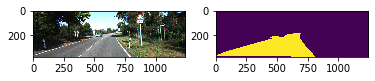

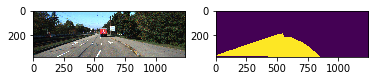

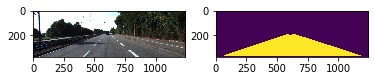

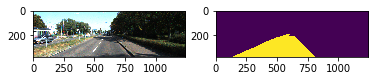

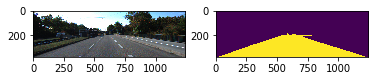

In [48]:
for index, image in enumerate(training_data.take(5)):
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(image['frame']))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(image['mask']))
    plt.show()

In [49]:
validation_frames_directory = training_directory + 'validation_frames'
validation_frames_directory = pathlib.Path(validation_frames_directory)
validation_frames = tf.data.Dataset.list_files(str(validation_frames_directory/'u*'))
validation_data = validation_frames.map(map_to_masks)

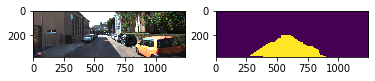

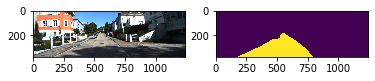

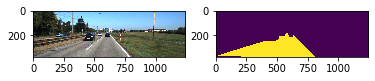

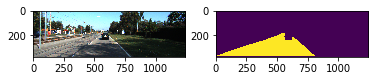

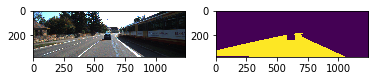

In [50]:
for index, image in enumerate(validation_data.take(5)):
    plt.subplot(1, 2, 1)
    plt.imshow(array_to_img(image['frame']))
    plt.subplot(1, 2, 2)
    plt.imshow(array_to_img(image['mask']))
    plt.show()

In [51]:
data_set = {'train': training_data, 'test': validation_data}

## Apply some data augmentation to the training data

The following functions are taken from: https://www.tensorflow.org/tutorials/images/segmentation<br>

In [52]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [53]:
@tf.function
def load_image_train(datapoint):
    input_image = tf.image.resize(datapoint['frame'], (375, 1242))
    input_mask = tf.image.resize(datapoint['mask'], (375, 1242))

    if (tf.random.uniform(()) > 0.5):
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [54]:
def load_image_test(datapoint):
    input_image = tf.image.resize(datapoint['frame'], (375, 1242))
    input_mask = tf.image.resize(datapoint['mask'], (375, 1242))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

# Training Hyperparameters

In [55]:
TRAIN_LENGTH = len(list(training_frames_directory.glob('**/*.png')))
BATCH_SIZE = 1
EPOCHS = 12000
VALIDATION_STEPS = 100
SAVE_CHECKPOINT_STEPS = 2000
SHOW_IMAGE = 150

BUFFER_SIZE = TRAIN_LENGTH + 1

# Prepare the data further

In [56]:
train = data_set['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = data_set['test'].map(load_image_test)

In [57]:
#train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat(count=3)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [58]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

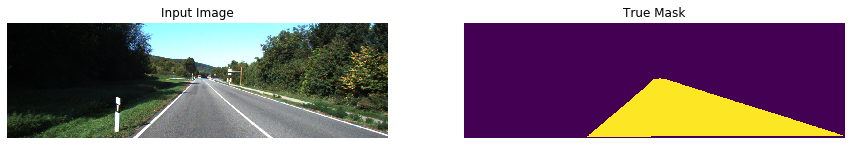

In [59]:
for image, mask in train.take(1):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [60]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [61]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask, create_mask(mm_model.predict(sample_image[tf.newaxis, ...]))])


In [62]:
class DisplayCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch % SHOW_IMAGE == 0):
            clear_output(wait=True)
            show_predictions()
            print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Define checkpoint callback

In [63]:
checkpoint_path = "mm_model_checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [64]:
cp_callback = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_freq=SAVE_CHECKPOINT_STEPS)

## Train the model and save intermediate results and the final version

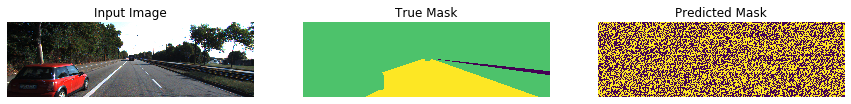


Sample Prediction after epoch 1

  4/231 [..............................] - ETA: 3:17:16 - loss: 128.6727 - accuracy: 0.4986

KeyboardInterrupt: 

In [80]:
model_history = mm_model.fit(train_dataset,
                             epochs=EPOCHS,
                             validation_steps=VALIDATION_STEPS,
                             validation_data=test_dataset,
                             callbacks=[DisplayCallback(), cp_callback])

In [ ]:
mm_model.save(filepath='mm_model.h5')
mm_model.save_weights(filepath='mm_model_weights')